Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score
! pip install scikit-plot
import scikitplot as skplt
import re
import os

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import Dataset,DataLoader
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn as nn
import torch.optim as optim
import math

In [5]:
data1 = pd.read_csv("/content/drive/MyDrive/markov/master_dataset.csv").fillna(' ')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = data1[data1.label_sexist == 'sexist']
ndf = data1[data1.label_sexist == 'not sexist']
add_df = ndf.sample(2000)
frames = [add_df,df]
data = pd.concat(frames)

Data Preprocessing

In [7]:
def clean_text(text):
    """Removes HTML tags and removes punctuation from the text"""
    text = text.lower() #lower case
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'www\S+', '', text)  # remove www website
    text = re.sub(r'<.*?>', '', text)  # remove html tags
    text = re.sub(r'[^\w\s]', '', text) # remove special characters like !,@,#,$,%
    text = re.sub('\s+', ' ', text) # replace multiple space by single space
    return text

def remove_stopword(text, stopwords):
    """Removes common words such as "the" and "a" from the text"""    
    return " ".join([word for word in text.split() if word not in (stop_words)])
  
def lemma_text(text, lemmatizer):
    """Reduces words to their base forms using lemmatization"""
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenize(text)]
    return " ".join(lemmatized_words)

def stem_text(text, stemmer):
    """Reduces words to their base forms using the provided stemmer"""
    stemmed_words = [stemmer.stem(word) for word in tokenize(text)]
    return " ".join(stemmed_words)

def tokenize(text):
    """Splits the text into individual words"""
    return text.split()

def process_text(text, lemmatizer, stemmer, stop_words):
    text = clean_text(text)
    text = remove_stopword(text, stop_words)
    #text = lemma_text(text, lemmatizer)
    #text = stem_text(text, stemmer)
    return text #tokenize(text) #START_TOKEN + " ".join(tokenize(text)) + STOP_TOKEN
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [8]:
# stores the result in a new column called 'processed_text'
data["processed_text"] = data['text'].apply(process_text, lemmatizer = lemmatizer, stemmer = stemmer, stop_words = stop_words)
data.head(5)

,text,label_sexist,processed_text
20994,"Unfortunately, this is an all too typical twit...",not sexist,unfortunately typical twitter response observa...
15701,There Is No Greater Motivation Than The Love O...,not sexist,greater motivation love woman happy womens day...
6229,#Illuminist 1%-er Sheryl Sandberg says her gre...,not sexist,illuminist 1er sheryl sandberg says great grea...
17198,Hope they get booted next round #kandre #MKR,not sexist,hope get booted next round kandre mkr
7451,"Yes ! I did this with one girl a while ago, un...",not sexist,yes one girl ago unfortunately different onlin...


In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(data['processed_text'], data['label_sexist'],stratify=data['label_sexist'], test_size=0.25)

In [10]:
labels = [str(i).split('/') for i in train_Y]
text= train_X

In [11]:
"""The code creates a Tf-idf vectorizer with a minimum document frequency of 5, 
applies it to a list of texts, then creates a multilabel binarizer and 
fits it to a list of labels. It creates arrays for the input and output features, and 
splits the data into training and test sets"""

tfidfvectorizer = TfidfVectorizer(min_df = 5) #max_features=3000
x_tfidf = tfidfvectorizer.fit_transform(text).toarray()
mlb = MultiLabelBinarizer()
mlb.fit(labels)
Y = mlb.transform(labels)
n_op_features = len(Y[0])
train_x,test_x,train_y,test_y = train_test_split(x_tfidf,Y,test_size=0.2)
n_ip_features = len(train_x[0])

In [12]:
class TextDataset(Dataset):
  '''This code block converts the arrays into tensors for pytorch.'''
  def __init__(self, X, y):
    self.X = torch.tensor(X)
    self.y = torch.tensor(y)
  def __len__(self):
    return len(self.y)
  def __getitem__(self,index):
    return self.X[index], self.y[index]

In [13]:
# DataLoader Definition
batch_size = 128
train_ds = TextDataset(X=train_x, y=train_y)
test_ds = TextDataset(X=test_x, y=test_y)
dataloader_train = DataLoader(dataset=train_ds,batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

In [14]:
class MLP(nn.Module):
  '''Multi-layered perceptron based classifier'''
  def __init__(self, num_features,out_features):
    """
    Args:
        num_features (int): the size of the input feature vector
    """
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(in_features=num_features, out_features=64)
    print("num f:", num_features)
    self.fc2 = nn.Linear(in_features=64,out_features=32)
    self.fc3 = nn.Linear(in_features=32,out_features=out_features)

  def forward(self, x_in, apply_softmax=False):
    """The forward pass of the classifier
    
    Args:
        x_in (torch.Tensor): an input data tensor. 
            x_in.shape should be (batch, num_features)
        apply_softmax (bool): a flag for the sigmoid activation
            should be false if used with the Cross Entropy losses
    Returns:
        the resulting tensor. tensor.shape should be (batch,)
    """
    y_out_1 = torch.relu(self.fc1(x_in))
    y_out_2 = self.fc2(y_out_1)
    y_out = self.fc3(y_out_2)
    return y_out

In [15]:
# CUDA
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [16]:
# Training the model
learning_rate=0.0001
num_epochs=20

epoch_loss_list=[]
epoch_acc_list=[]
val_epoch_acc_list=[]
val_epoch_loss_list=[]

model = MLP(n_ip_features,n_op_features)
model.to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

n_iter=math.ceil(len(train_ds)/batch_size)
print(n_iter)

losses = []
for epoch in range(num_epochs):
  epoch_loss = 0
  epoch_acc=0
  val_epoch_loss=0
  val_epoch_acc=0
  for k,(X,y) in enumerate(dataloader_train):
    # the training routine is these 5 steps:

    # step 1. load the data
    X = X.to(device)
    y = y.to(device)
    optimizer.zero_grad()

    # step 2. compute the output
    y_pred = model(x_in=X.float())
    y_1 = (y_pred).to('cpu').detach().numpy()
    y_1=(np.array(y_1) >= 0)*1
    y_0=y.to('cpu').detach().numpy()
    acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
    epoch_acc+= acc

    # step 3. compute the loss
    loss = loss_func(y_pred, y.squeeze(1).float())
    epoch_loss+= loss.item()

    # step 4. use loss to produce gradients
    loss.backward()

    # step 5. use optimizer to take gradient step
    optimizer.step()
  epoch_loss = round(epoch_loss/(k+1),3)
  epoch_loss_list.append(epoch_loss)
  epoch_acc = round(epoch_acc/len(train_ds),3)
  epoch_acc_list.append(epoch_acc)
  
  for k,(X,y) in enumerate(dataloader_test):
    X = X.to(device)
    y = y.to(device)
    y_pred = model(x_in=X.float())
    y_1 = (y_pred).to('cpu').detach().numpy()
    y_1=(np.array(y_1) >= 0)*1
    y_0=y.to('cpu').detach().numpy()
    val_acc = sum([(y_0[i]==y_1[i]).all()*1 for i in range(len(y_0))])
    val_epoch_acc+=val_acc
    loss = loss_func(y_pred, y.squeeze(1).float())
    val_epoch_loss+= loss.item()

  val_epoch_acc=round(val_epoch_acc/len(test_ds),3)
  val_epoch_acc_list.append(val_epoch_acc)
  val_epoch_loss = round(val_epoch_loss/(k+1),3)
  val_epoch_loss_list.append(val_epoch_loss)
  print('epoch : ' + str(epoch+1)+'/'+str(num_epochs))
  print("-"*40)
  print('loss : ' + str(epoch_loss)+ ' \t val loss : '+ str(val_epoch_loss)+ '\nacc :' + str(epoch_acc)+ ' \t val acc :' + str(val_epoch_acc))
  print("+"*40)  # -----------------------------------------
  losses.append(epoch_loss)

num f: 1997
37
epoch : 1/20
----------------------------------------
loss : 0.697 	 val loss : 0.693
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 2/20
----------------------------------------
loss : 0.689 	 val loss : 0.685
acc :0.0 	 val acc :0.0
++++++++++++++++++++++++++++++++++++++++
epoch : 3/20
----------------------------------------
loss : 0.679 	 val loss : 0.673
acc :0.001 	 val acc :0.01
++++++++++++++++++++++++++++++++++++++++
epoch : 4/20
----------------------------------------
loss : 0.664 	 val loss : 0.657
acc :0.467 	 val acc :0.729
++++++++++++++++++++++++++++++++++++++++
epoch : 5/20
----------------------------------------
loss : 0.645 	 val loss : 0.64
acc :0.746 	 val acc :0.734
++++++++++++++++++++++++++++++++++++++++
epoch : 6/20
----------------------------------------
loss : 0.621 	 val loss : 0.614
acc :0.747 	 val acc :0.734
++++++++++++++++++++++++++++++++++++++++
epoch : 7/20
----------------------------------------
loss : 0.59

In [20]:
def plot_graph(plot_var,train_plot_list,val_plot_list):
  '''Function for visualizing the Accuracy and Loss'''
  epochs = len(train_plot_list)
  fig = plt.figure(figsize=(8,6))
  if plot_var=="accuracy": plt.title("Train/Validation Accuracy")
  elif plot_var =="loss" : plt.title("Train/Validation Loss")
  plt.plot(list(np.arange(epochs) + 1) , train_plot_list, label='train')
  plt.plot(list(np.arange(epochs) + 1), val_plot_list, label='validation')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.legend(loc='best')
  if plot_var=="accuracy": plt.savefig("/content/drive/MyDrive/markov/task_a_train_Val_accuracy.png")
  elif plot_var =="loss" : plt.savefig("/content/drive/MyDrive/markov/task_a_train_Val_loss.png")
  return

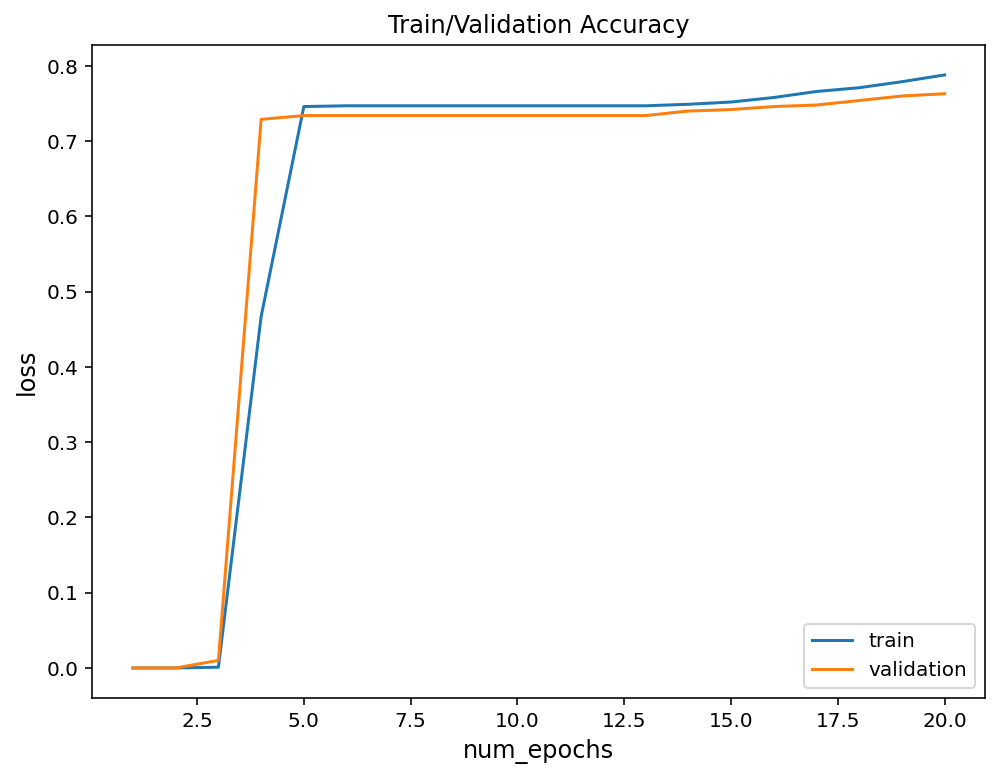

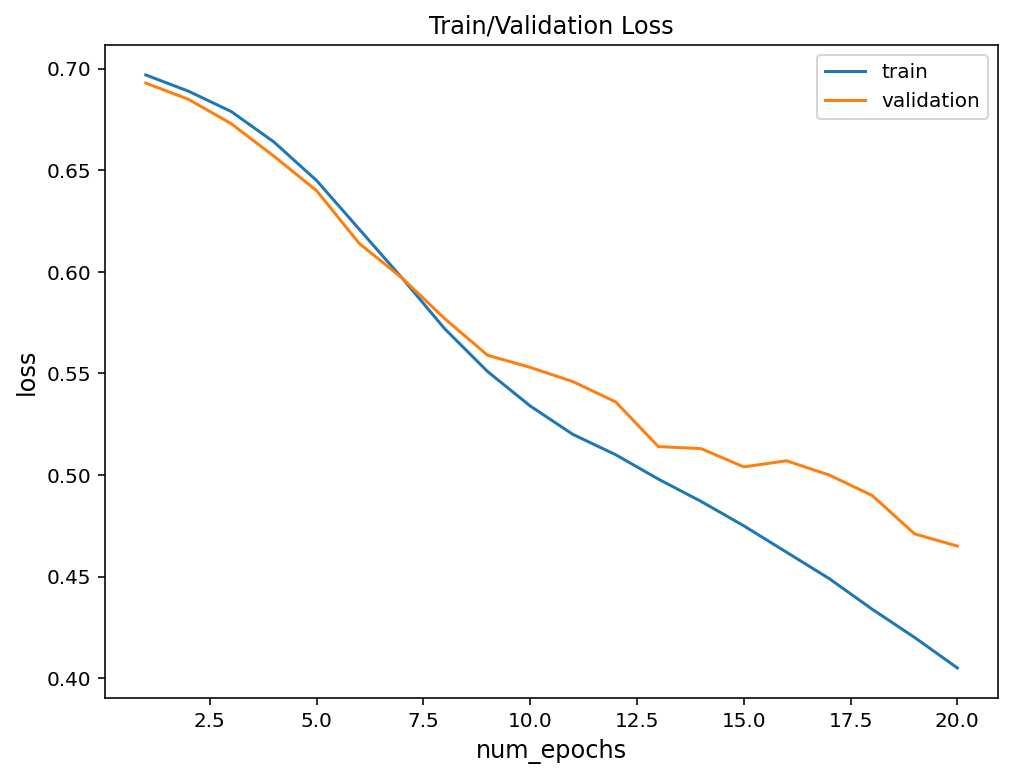

In [21]:
# visualizing the Accuracy and Loss
plot_graph("accuracy",epoch_acc_list, val_epoch_acc_list)
plot_graph("loss",epoch_loss_list, val_epoch_loss_list)

In [22]:
# Converting testing elements to torch tensor from array
test_x = torch.Tensor(test_x)
y_pred = model(test_x.to(device)) 
print(y_pred.shape, test_x.shape)

torch.Size([1175, 2]) torch.Size([1175, 1997])


In [23]:
def multilabel_predict(x):
  '''Function to get predicted labels for testing data'''
  x = tfidfvectorizer.transform([x]).toarray()
  x = torch.tensor(x, dtype=torch.float64)
  pred = model(x_in=x.float().to(device))
  y_1 = (pred).to('cpu').detach().numpy()
  ind=(y_1).argmax(axis = 1)
  y_dim = y_1.shape[1]
  l = [0 for i in range(y_dim)]
  for i in range(y_dim):
      if i==ind:
          l[i] = 1
  #y_1 = np.array(l)
  #print(y_1)
  y_1 = mlb.inverse_transform(np.array(l).reshape(1,2))
  return y_1

In [24]:
# Getting relations for plotting Confusion Matrix
test_utterences= test_X
predicted_relations=[]
for utterence in test_utterences:
  test_pred=multilabel_predict(utterence)
  predicted_relations.append(test_pred[0])
print(len(predicted_relations))

1958


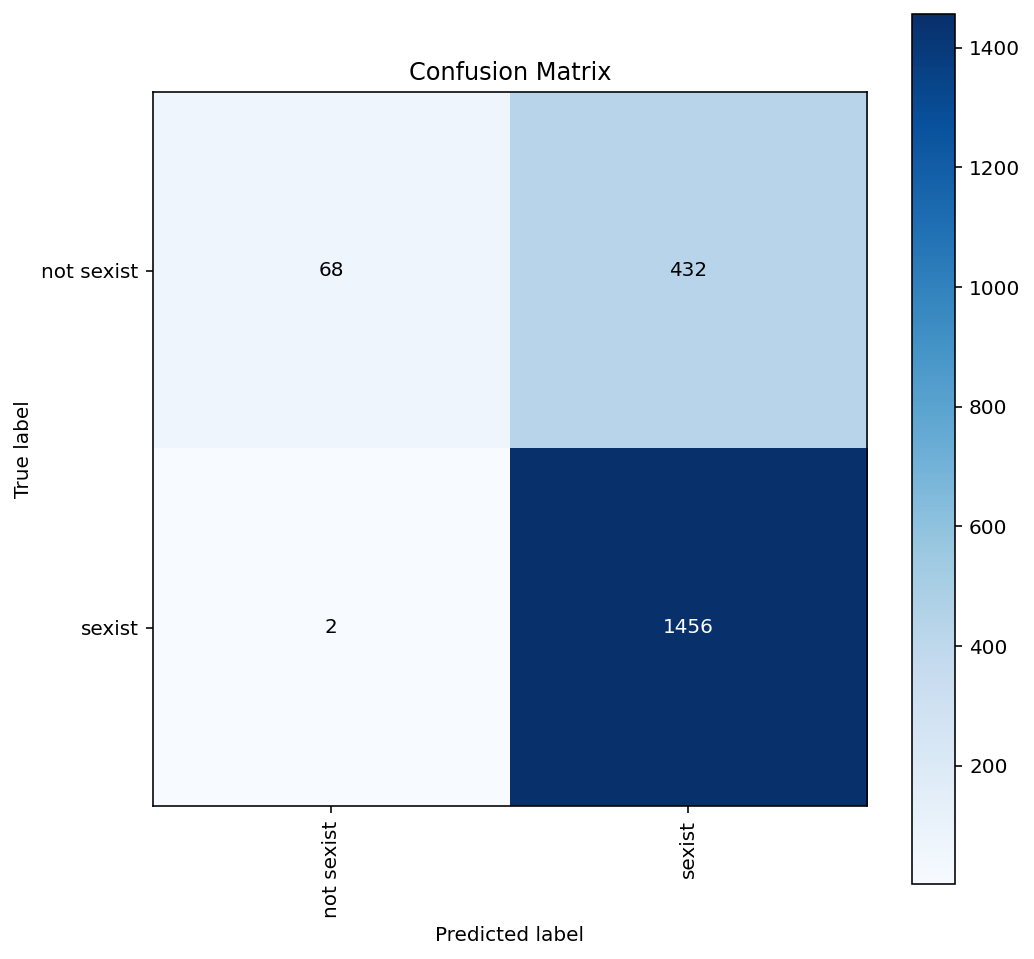

In [25]:
# Plotting Confusion Matrix
y_true = [x for x in test_Y]
y_pred = [x for x in predicted_relations]
skplt.metrics.plot_confusion_matrix(y_true, y_pred, figsize=(8,8),x_tick_rotation=90)
plt.savefig("/content/drive/MyDrive/markov/task_a_confusion_matrix.png")

In [26]:
# Evaluation Report
print(classification_report(y_true,y_pred))
clsf_report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True)).transpose()
clsf_report.to_csv("/content/drive/MyDrive/markov/task_a_classification_report.csv", index= True)

              precision    recall  f1-score   support

  not sexist       0.97      0.14      0.24       500
      sexist       0.77      1.00      0.87      1458

    accuracy                           0.78      1958
   macro avg       0.87      0.57      0.55      1958
weighted avg       0.82      0.78      0.71      1958



In [ ]:
# saving the model and prediction using it
torch.save(model.state_dict(), 'trained_model3.pth')

In [ ]:
def predict_sexism(x):
  x = tfidfvectorizer.transform([x]).toarray()
  x = torch.tensor(x, dtype=torch.float64)
  model.load_state_dict(torch.load('trained_model3.pth'))
  pred = model(x_in=x.float().to(device))
  y_1 = (pred).to('cpu').detach().numpy()
  ind=(y_1).argmax(axis = 1)
  y_dim = y_1.shape[1]
  l = [0 for i in range(y_dim)]
  for i in range(y_dim):
      if i==ind:
          l[i] = 1
  y_1 = mlb.inverse_transform(np.array(l).reshape(1,2))
  return y_1

In [ ]:
t1 = "women are weak and inferior"
test_pred=predict_sexism(t1)
print(test_pred)